In [1]:
%matplotlib inline
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from gravdark.stsp import STSP
from gravdark import hat7_params, LightCurve, concatenate_light_curves

In [2]:
h7_path = glob('/Users/bmmorris/data/gravdark/hat7/*slc.fits')
h7_lc_whole = LightCurve.from_raw_fits(h7_path, name='HAT-P-7 b')

h7_masked = LightCurve(**h7_lc_whole.mask_out_of_transit(hat7_params(), oot_duration_fraction=0.5))
h7_transits = h7_masked.get_transit_light_curves(hat7_params())
for transit in h7_transits:
    transit.remove_linear_baseline(hat7_params())
h7 = concatenate_light_curves(h7_transits)

params = hat7_params()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:849: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:850: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:374: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:375: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an er

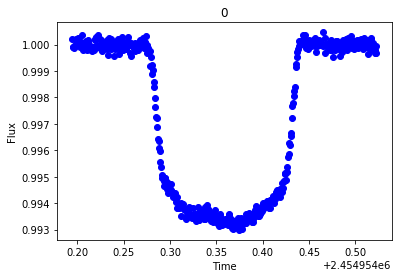

In [89]:
h7 = h7_transits[0]

h7.plot()

In [90]:
stsp = STSP(h7, params, [0.1, 1.5, 1.5])

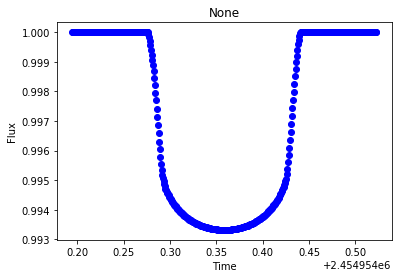

In [91]:
lc = stsp.stsp_lc()

lc.plot()

In [92]:
[0.1, np.radians(90+23), np.radians(0.01)]

[0.1, 1.9722220547535925, 0.00017453292519943296]

In [93]:
for attr in dir(params):
    if not attr.startswith('_'):
        print(attr, getattr(params, attr))

a 4.1545
b 0.49723805
duration 0.16430159
ecc 0.0
fp None
inc 83.143
inc_stellar 75
lam 155
limb_dark quadratic
per 2.2047354
per_rot 2.2047354
rp 0.07754991940679243
t0 2454954.35853331
t_secondary None
u [0.3492, 0.1733]
w 1.5707963267948966


In [94]:
# x, y, error = np.loadtxt("data/residuals.txt", unpack=True)

# h7 = LightCurve(times=(x+params.t0)*params.per, fluxes=y, errors=error)

# plt.errorbar(x, y, error)

In [95]:
def gaussian(p, x):
    amp, t0, sig = p
    return np.exp(-0.5 * (t0 - x)**2/sig**2)
# residual gaussian fit from fasthat7
bestp = np.array([1.86737477e-05, -1.65111705e-02, 9.76215571e-03])
observed_residuals = gaussian(bestp, h7.phases(params))

def chi2(max_residuals):
    return np.sum((max_residuals/max_residuals.max() - observed_residuals)**2)
    #return np.sum((max_residuals/max_residuals.max() - y)**2/error**2)

def compute_max_residuals(lat, inc_stellar, lam, delta_longitude=15):
    params.inc_stellar = inc_stellar
    params.lam = lam
    max_residuals = np.zeros(h7.times.jd.shape)

    for lon in np.arange(0, 360, delta_longitude):
        with STSP(h7, params, [0.1, np.radians(lat), np.radians(lon)]) as stsp:
            lc = stsp.stsp_lc(verbose=False)
            residuals = lc.fluxes - lc.transit_model(params)
            max_residuals = np.max(np.vstack([max_residuals, residuals]).T, axis=1)
    return max_residuals

def model(lat, inc_stellar, lam):
    max_residuals = compute_max_residuals(lat, inc_stellar, lam)
    return chi2(max_residuals)

#         ax[0].plot(lc.times.jd, lc.fluxes)
#         ax[1].plot(lc.times.jd, residuals)

[lund 2014](https://www-aanda-org.offcampus.lib.washington.edu/articles/aa/pdf/2014/10/aa24326-14.pdf)

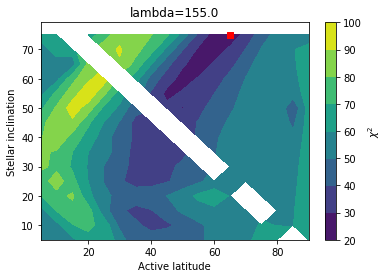

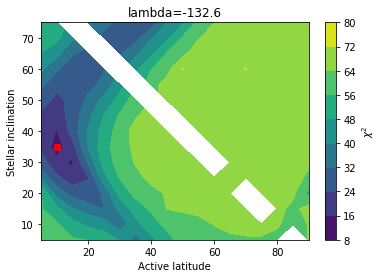

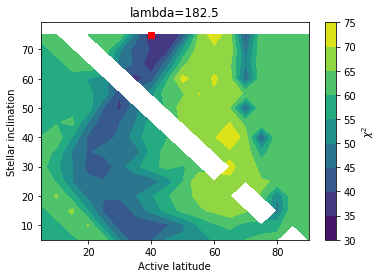

In [96]:
from astropy.utils.console import ProgressBar

test_latitudes = np.arange(5, 95, 5)
test_inc_stellars = np.arange(5, 80, 5)
lams = [155, -132.6, 182.5]

for lam in lams:
    chi2s = []

    with ProgressBar(len(test_latitudes) * len(test_inc_stellars), ipython_widget=True) as bar:
        for test_lat in test_latitudes:
            chi2_lat = []
            for test_inc in test_inc_stellars:
                bar.update()
                chi2_lat.append(model(test_lat, test_inc, lam))
            chi2s.append(chi2_lat)
    chi2s = np.array(chi2s).reshape((test_latitudes.shape[0], test_inc_stellars.shape[0])).T

    minchi2 = np.unravel_index(np.nanargmin(chi2s), chi2s.shape)
    X, Y = np.meshgrid(test_latitudes, test_inc_stellars)

    best_lat, best_inc = test_latitudes[minchi2[1]], test_inc_stellars[minchi2[0]]
    cax = plt.contourf(X, Y, chi2s)
    plt.scatter(best_lat, best_inc, marker='s', color='r')
    plt.xlabel('Active latitude')
    plt.ylabel('Stellar inclination')
    plt.colorbar(cax, label='$\chi^2$')
    plt.title('lambda={0:.1f}'.format(lam))
    plt.show()

In [71]:
# minchi2 = np.unravel_index(np.nanargmin(chi2s), chi2s.shape)
# X, Y = np.meshgrid(test_latitudes, test_inc_stellars)

# best_lat, best_inc = test_latitudes[minchi2[1]], test_inc_stellars[minchi2[0]]
# cax = plt.contourf(X, Y, chi2s)
# plt.scatter(best_lat, best_inc, marker='s', color='r')
# plt.xlabel('Active latitude')
# plt.ylabel('Stellar inclination')
# plt.colorbar(cax, label='$\chi^2$')

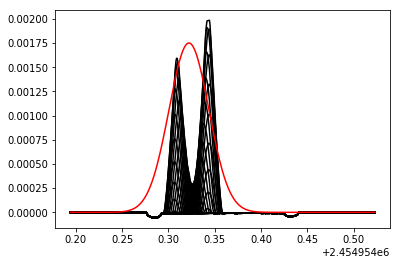

In [70]:
params.lam = -132.6
params.inc_stellar = 35

delta_longitude = 5
for lon in np.arange(0, 360, delta_longitude):
    with STSP(h7, params, [0.1, np.radians(15), np.radians(lon)]) as stsp:
        lc = stsp.stsp_lc(verbose=False)
        plt.plot(lc.times.jd, lc.fluxes - lc.transit_model(params), color='k')
plt.plot(lc.times.jd, observed_residuals*0.00175, 'r')

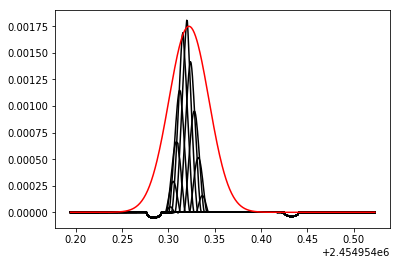

In [98]:
params.lam = 155
params.inc_stellar = 75

delta_longitude = 5
for lon in np.arange(0, 360, delta_longitude):
    with STSP(h7, params, [0.1, np.radians(65), np.radians(lon)]) as stsp:
        lc = stsp.stsp_lc(verbose=False)
        plt.plot(lc.times.jd, lc.fluxes - lc.transit_model(params), color='k')
plt.plot(lc.times.jd, observed_residuals*0.00175, 'r')

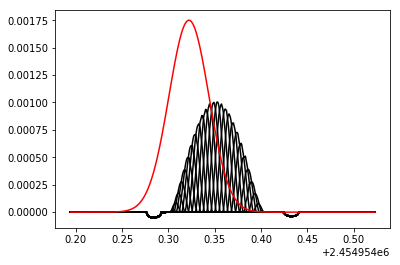

In [72]:
params.lam = 182
params.inc_stellar = 75

delta_longitude = 5
for lon in np.arange(0, 360, delta_longitude):
    with STSP(h7, params, [0.1, np.radians(40), np.radians(lon)]) as stsp:
        lc = stsp.stsp_lc(verbose=False)
        plt.plot(lc.times.jd, lc.fluxes - lc.transit_model(params), color='k')
plt.plot(lc.times.jd, observed_residuals*0.00175, 'r')